In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
countires = [ 
    "Algeria",
    "Angola",
    "Benin",
    "Botswana",
    "Burkina Faso",
    "Burundi",
    "Cabo Verde",
    "Cameroon",
    "Central African Republic",
    "Chad",
    "Comoros",
    "Congo",
    "Côte d'Ivoire",
    "Djibouti",
    "Egypt",
    "Eritrea",
    "Eswatini",
    "Ethiopia",
    "Gabon",
    "Gambia",
    "Ghana",
    "Guinea",
    "Guinea-Bissau",
    "Kenya",
    "Lesotho",
    "Libya",
    "Madagascar",
    "Malawi",
    "Mali",
    "Mauritania",
    "Mauritius",
    "Morocco",
    "Mozambique",
    "Namibia",
    "Niger",
    "Nigeria",
    "Rwanda",
    "Sao Tome and Principe",
    "Senegal",
    "Sierra Leone",
    "Somalia",
    "South Africa",
    "South Sudan",
    "Sudan",
    "Sudan (former)",
    "Togo",
    "Uganda",
    "Zambia",
    "Zimbabwe"
]


In [3]:
Yields = pd.read_csv('/home/dgorrell/Downloads/Maize-10-17-2019.csv') #Change name of the dataset to casava. We will beable to compare for different datasets
Temp = pd.read_csv('/home/dgorrell/Downloads/GlobalTemperatures.csv')
Preception = pd.read_csv('/home/dgorrell/Downloads/precipitation_perCountry_perYear.csv')

In [4]:
# Creating a list of years present in our data
years = np.unique(Temp['dt'].apply(lambda x: x[:4]))
mean_temp_world = []
mean_temp_world_uncertainty = []

for year in years:
    mean_temp_world.append(Temp[Temp['dt'].apply(
        lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
    mean_temp_world_uncertainty.append(Temp[Temp['dt'].apply(
                lambda x: x[:4]) == year]['LandAverageTemperatureUncertainty'].mean())

In [5]:
#Let's remove the duplicated countries (in the analysis, we don't consider the presence of 
#colonies at this the countries) and countries for which no information about the temperature
global_temp_country = pd.read_csv('/home/dgorrell/Downloads/GlobalLandTemperaturesByCountry.csv')
global_temp_country["Country"].unique()
global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]
#global_temp_country_clear["Country"].unique()
global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)', 'Cape Verde'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom', 'Cabo Verde'])

In [6]:
mean_temp_year_country = [ [0] * len(years[0:]) for i in range(len(countires))]
j = 0
for country in countires:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[0:]:
        mean_temp_year_country[j][i] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

IndexError: index 38 is out of bounds for axis 0 with size 38

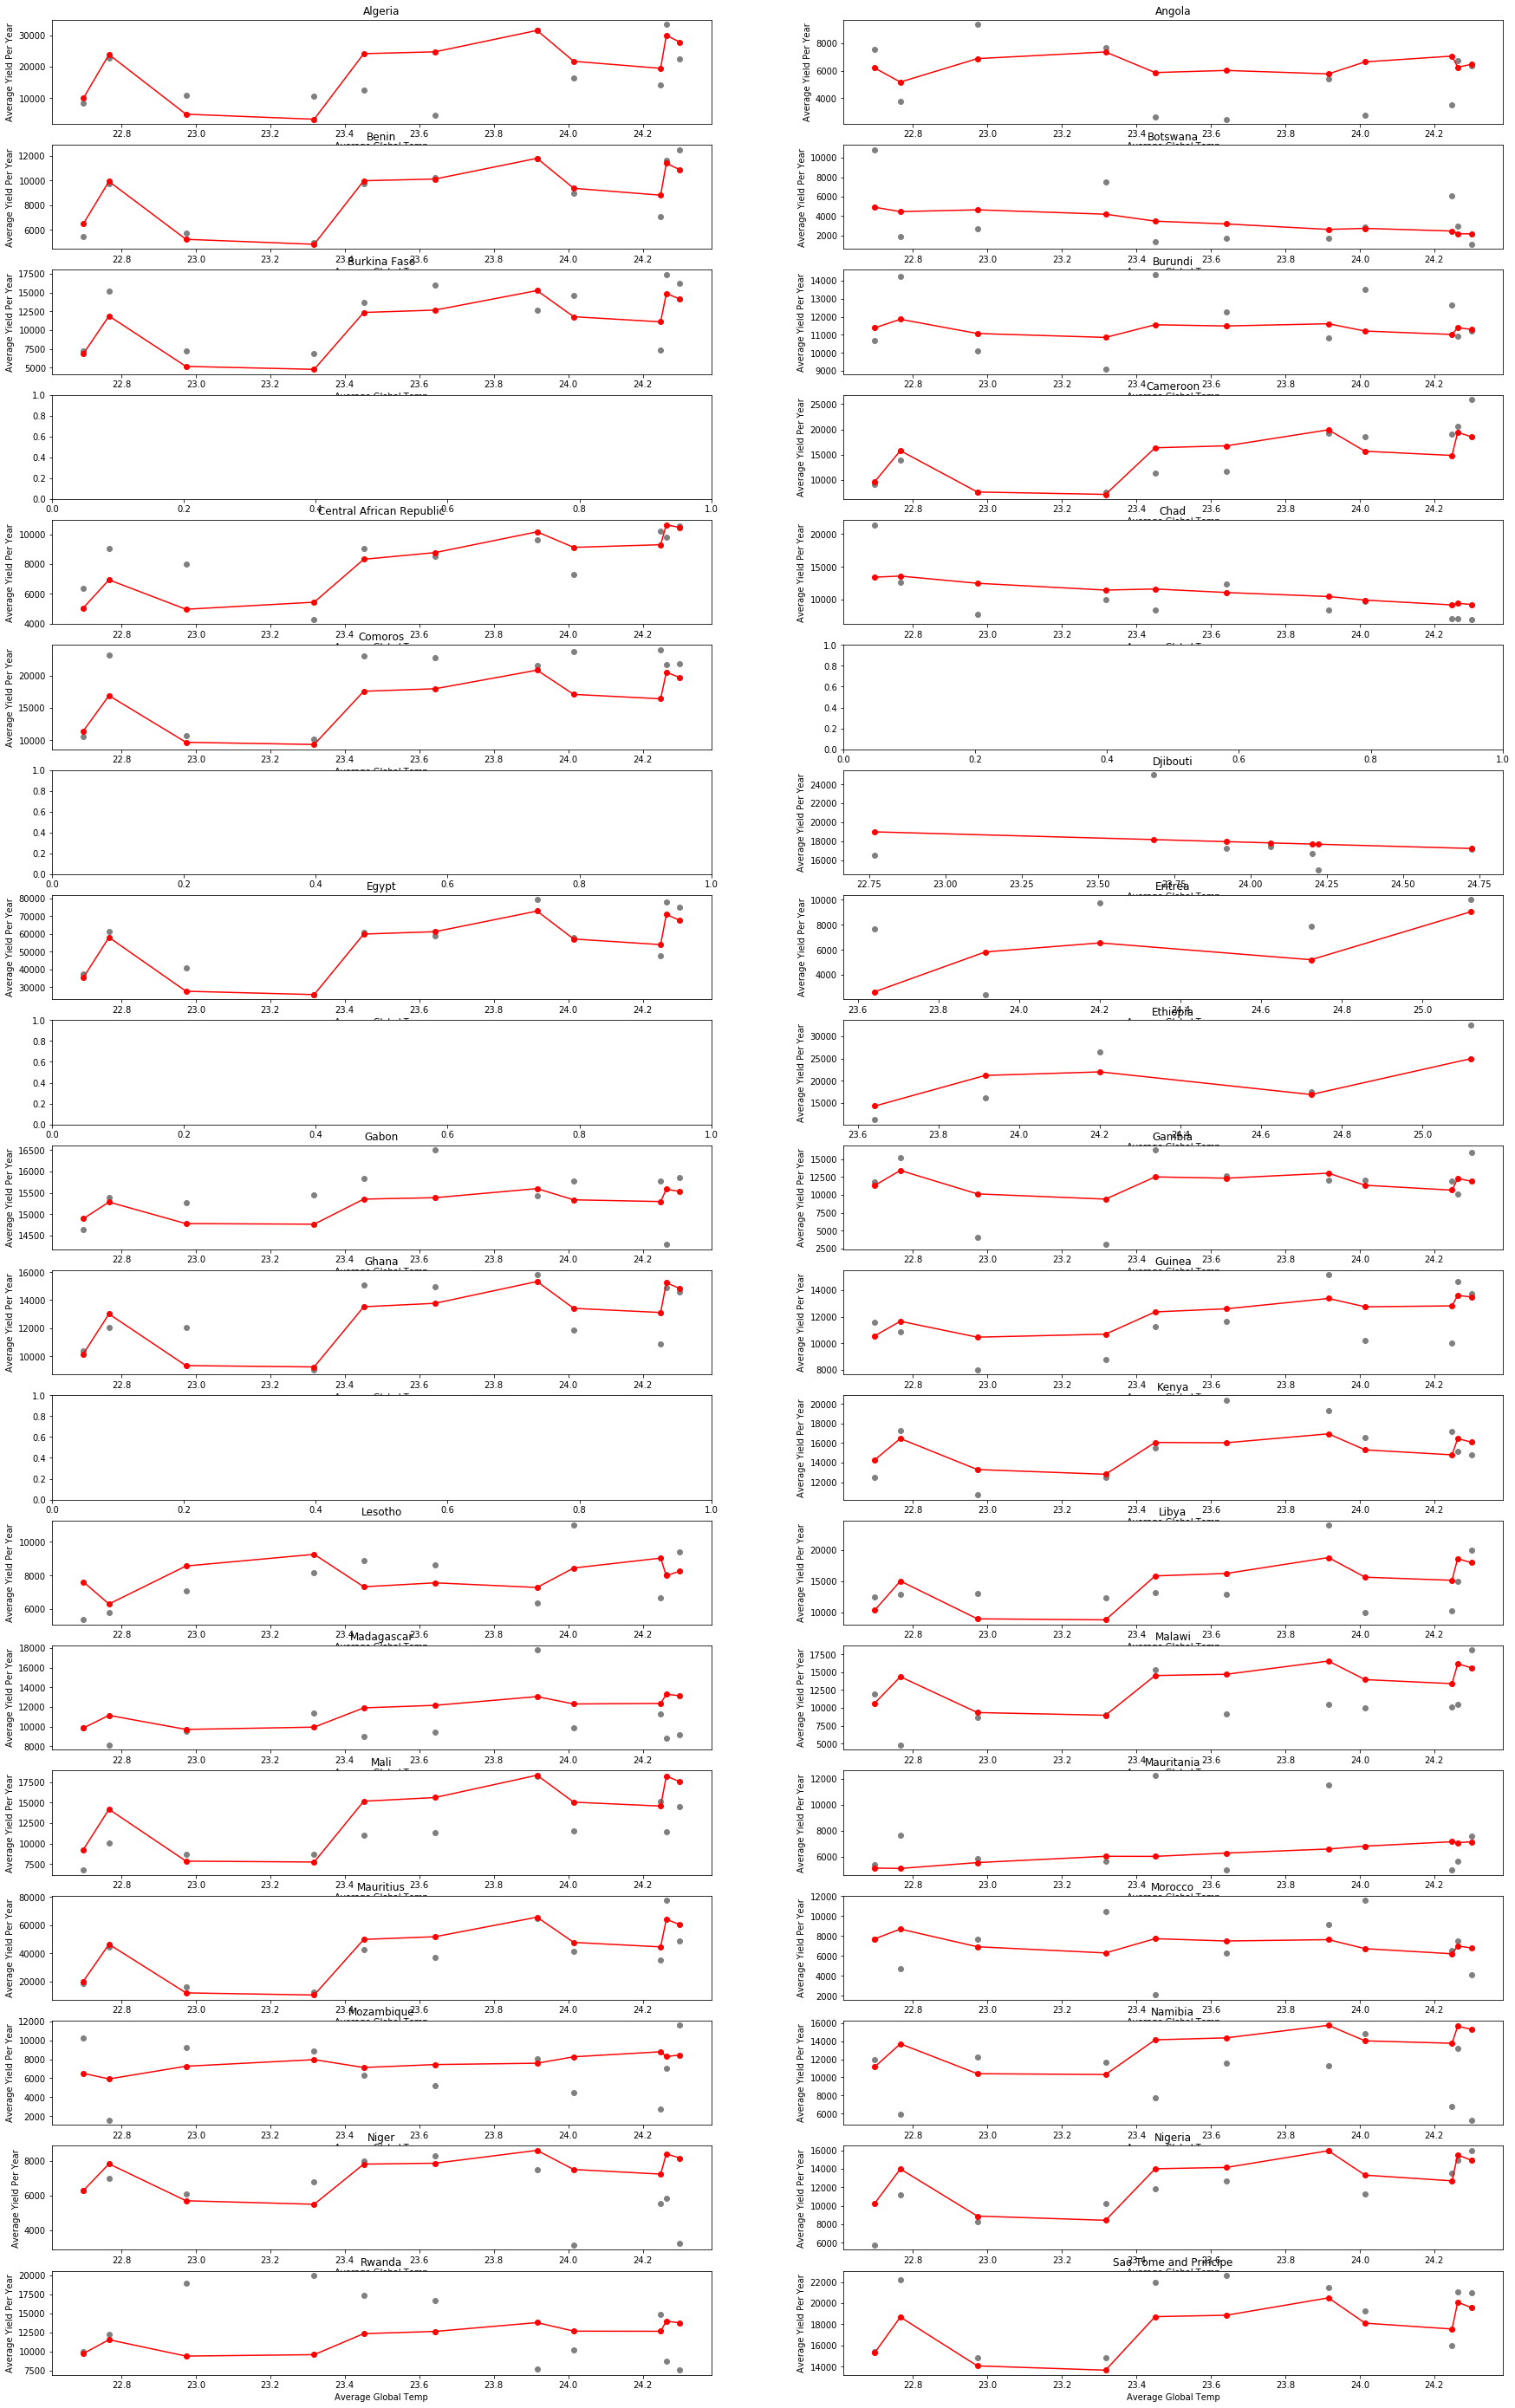

In [7]:
fig, axmatrix = plt.subplots(19,2, figsize = (30, 50))
ax = axmatrix.flatten()
for iplot, COUNTRY in enumerate (countires):
    # Creating masks for yields country
    maskCountry = Yields["Area"] == COUNTRY 
    yearsInCountry = Yields["Year"][maskCountry]
    yieldsInCountry = Yields["Value"][maskCountry]
    
    # Creating masks for precepitation
    maskPreception = Preception["country"] == COUNTRY
    yearsInPreception = np.array(Preception["year"][maskPreception]).astype("int")
    preceptionInCountry = Preception["total_rainfall"][ maskPreception]
    if len(preceptionInCountry) >0:
    
    # Creating masks for temp
        maskedTempCountry = countires == COUNTRY
        tempInCountry = np.array(mean_temp_year_country[maskedTempCountry])
        yearsInCountryTemp = np.array(years).astype("int")

        # Making sure that things are over the same year range
        minAll = max([yearsInCountryTemp.min(),yearsInCountry.min(), yearsInPreception.min()])
        maxAll = min([yearsInCountryTemp.max(),yearsInCountry.max(), yearsInPreception.max()])
        
        # For Yields 
        yearsYieldsInCountryMasked = yearsInCountry[(yearsInCountry >= minAll) & (yearsInCountry <= maxAll)]
        yieldsInCountryMasked = yieldsInCountry[(yearsInCountry >= minAll) & (yearsInCountry <= maxAll)] 
        
        # for Preceptation
        yearsPrecepInCountryMasked = yearsInPreception[(yearsInPreception >= minAll) & (yearsInPreception <= maxAll)]
        precepInCountryMasked = preceptionInCountry[(yearsInPreception >= minAll) & (yearsInPreception <= maxAll)] 
        
        # For Temp
        yearsInCountryMasked = yearsInCountryTemp[(yearsInCountryTemp >= minAll) & (yearsInCountryTemp <= maxAll)]
        tempInCountryMasked = tempInCountry[(yearsInCountryTemp >= minAll) & (yearsInCountryTemp <= maxAll)] 

        # Masking All to same year subset
        
        # Masking Temp
        maskTemp = np.in1d(yearsInCountryMasked, yearsYieldsInCountryMasked)
        tempInCountryMasked = tempInCountryMasked[maskTemp]
        
        # Masking Yields
        maskYield = np.in1d(yearsYieldsInCountryMasked, yearsInCountryMasked)
        yieldsInCountryMasked = yieldsInCountryMasked[maskYield]
        finalYearsMaksedInYields = yearsYieldsInCountryMasked[maskYield]
        
        # Maksing Precep 
        maskPrecep = np.in1d(yearsPrecepInCountryMasked, finalYearsMaksedInYields)
        precepInCountryMasked = yearsPrecepInCountryMasked[maskPrecep]

        # Now Linear Regression
        # This is creating our repsonse variable 
        y = yieldsInCountryMasked.values#.reshape(-1,1)
        # We are masking out NaNs in the Temp data
        mask = ~np.isnan(tempInCountryMasked)
        tempInCountryMasked = tempInCountryMasked[mask]
        y = y[mask]
        precepInCountryMasked = precepInCountryMasked[mask]
        
        # We are masking out NaNs in the Yields data, which we have defined by the variable y
        mask = ~np.isnan(y)
        #print(len(tempInCountryMasked), len(mask))
        tempInCountryMasked = tempInCountryMasked[mask]
        y = y[mask]
        precepInCountryMasked = precepInCountryMasked[mask]
        
        # We are masking out NaNs in the Precep data
        mask = ~np.isnan(precepInCountryMasked)
        tempInCountryMasked = tempInCountryMasked[mask]
        y = y[mask]
        precepInCountryMasked = precepInCountryMasked[mask]

        # Reformat input so that they fit the linear regression
        y = y.reshape(-1,1)
        
        # combine precp and temp data into our x variable for input
        X = np.zeros([len(precepInCountryMasked), 2])
        X[:,0] = tempInCountryMasked
        X[:,1] = precepInCountryMasked
        
        length_of_real_values = len(X[~np.isnan(X)])
        # Doing Linear Regression
        if length_of_real_values >0:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            # Indext's possible that there are Nan, + or - infintaties that may cause us errors 
            #mask = np.isnan(X_train)
            #X_train = X_train[~mask].reshape(-1,1)
            #y_train = y_train[~mask].reshape(-1,1)
            regressor = LinearRegression()
            regressor.fit(X_train, y_train) #training the algorithm
            y_pred = regressor.predict(X_test)
            df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
            xplt = X_test[:,0]
            yplt = y_test
            index = np.argsort(xplt)
            yplt = yplt[index]
            xplt = xplt[index]
            yPredicPlt = y_pred[index]
            ax[iplot].scatter(xplt, yplt,  color='gray')
            ax[iplot].plot(xplt, yPredicPlt, "ro")
            ax[iplot].plot(xplt, yPredicPlt, "r")
            ax[iplot].set_xlabel("Average Global Temp") 
            ax[iplot].set_ylabel("Average Yield Per Year")
            ax[iplot].set_title(COUNTRY)
plt.show()